In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    SmartCorrelatedSelection
)
from feature_engine.imputation import MeanMedianImputer

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

In [19]:
df_train = pd.read_csv('/Users/tanmaysharma/projects/Jak2Biotech/Datasets/jak2train.csv')
df_test = pd.read_csv('/Users/tanmaysharma/projects/Jak2Biotech/Datasets/jak2test.csv')

In [20]:
df_train.dropna(axis=1, thresh= 0.3*len(df_train), inplace=True)

In [24]:
pipe = Pipeline([
    ('fillNa', MeanMedianImputer(imputation_method = 'median')), # imputes medain in na values
    ('constant', DropConstantFeatures(tol=0.98)), # drops constant and quazi constant features
    ('duplicated', DropDuplicateFeatures()), # drop the exact same features
    ('correlation', SmartCorrelatedSelection( # drops correlated
        threshold=0.8,
        selection_method="model_performance",
        estimator=ExtraTreesClassifier()
    ))
])

In [25]:
exp_df = pipe.fit(df_train.drop(['cls'], axis = 1), df_train['cls'])

In [26]:
exp_df

Pipeline(steps=[('fillNa', MeanMedianImputer()),
                ('constant', DropConstantFeatures(tol=0.98)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=ExtraTreesClassifier(),
                                          selection_method='model_performance'))])

In [29]:
exp_df_train = pipe.transform(df_train.drop(['cls'], axis = 1))

In [30]:
exp_df_train.shape

(9440, 425)

In [31]:
df_test = df_test[df_train.columns]

In [36]:
exp_df_test = pipe.transform(df_test.drop(['cls'], axis = 1))

In [37]:
exp_df_test.shape

(2360, 425)

In [38]:
y_train = df_train['cls']
y_test = df_test['cls']

In [41]:
exp_df_train['cls'] = y_train
exp_df_test['cls'] = y_test

In [42]:
import umap

In [53]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(exp_df_train.drop(['cls', 'name'], axis = 1))
embedding_df = pd.DataFrame(data=embedding, columns=['UMAP_1', 'UMAP_2'])
embedding_df['target'] = exp_df_train['cls']

/Users/tanmaysharma/projects/Jak2Biotech/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


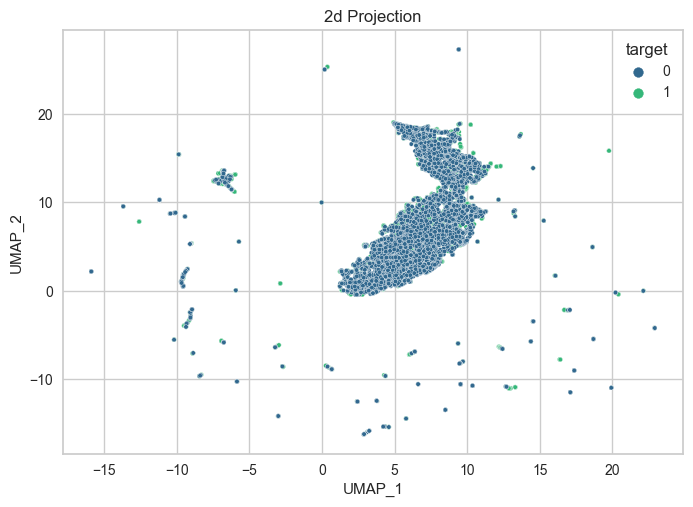

In [54]:
import seaborn as sns

sns.scatterplot(data=embedding_df, x='UMAP_1', y='UMAP_2', hue='target', palette='viridis', legend='full', s=10)
plt.title("2d Projection")
plt.show()

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

temp_X_train, temp_X_test, temp_y_train, temp_y_test = train_test_split(
    embedding_df_3d.drop(['target'], axis = 1), 
    embedding_df_3d['target'], 
    stratify = embedding_df['target'],
    random_state = 42,
    shuffle = True,
    test_size = 0.25
)

xgb = XGBClassifier()
xgb_model = xgb.fit(temp_X_train, temp_y_train)
xgb_predict = xgb_model.predict(temp_X_test)
accuracy_score(temp_y_test, xgb_predict)

0.6593220338983051

In [46]:
from mpl_toolkits.mplot3d import Axes3D

In [55]:
reducer_3d = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='euclidean')  
embedding_3d = reducer_3d.fit_transform(exp_df_train.drop(['cls', 'name'], axis = 1))
embedding_df_3d = pd.DataFrame(data=embedding_3d, columns=['UMAP_1', 'UMAP_2', 'UMAP_3'])
embedding_df_3d['target'] = exp_df_train['cls']

/Users/tanmaysharma/projects/Jak2Biotech/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


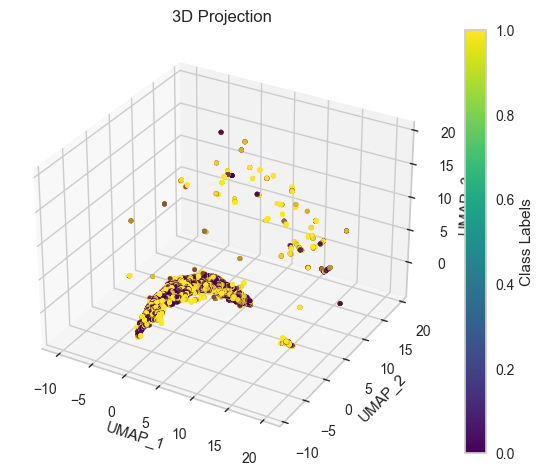

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_df_3d['UMAP_1'], embedding_df_3d['UMAP_2'], embedding_df_3d['UMAP_3'], c=embedding_df_3d['target'], cmap='viridis', s=10)
ax.set_title("3D Projection")
ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
ax.set_zlabel("UMAP_3")
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')
plt.show()

In [39]:
from pycaret.classification import *

In [65]:
exp = setup(
    data = exp_df_train,
    target = 'cls',
    index = False,
    test_data = exp_df_test,
    text_features = ['name'],
    text_features_method = 'tf-idf',
    remove_outliers = 'ee',
    normalize = True,
    normalize_method = 'zscore',
    n_jobs = -1
)

/Users/tanmaysharma/projects/Jak2Biotech/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/tanmaysharma/projects/Jak2Biotech/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [68]:
best_models = compare_models(
    sort = 'Accuracy',
    n_select = 5
)

In [69]:
nb = create_model('nb')

In [70]:
et = create_model('et')

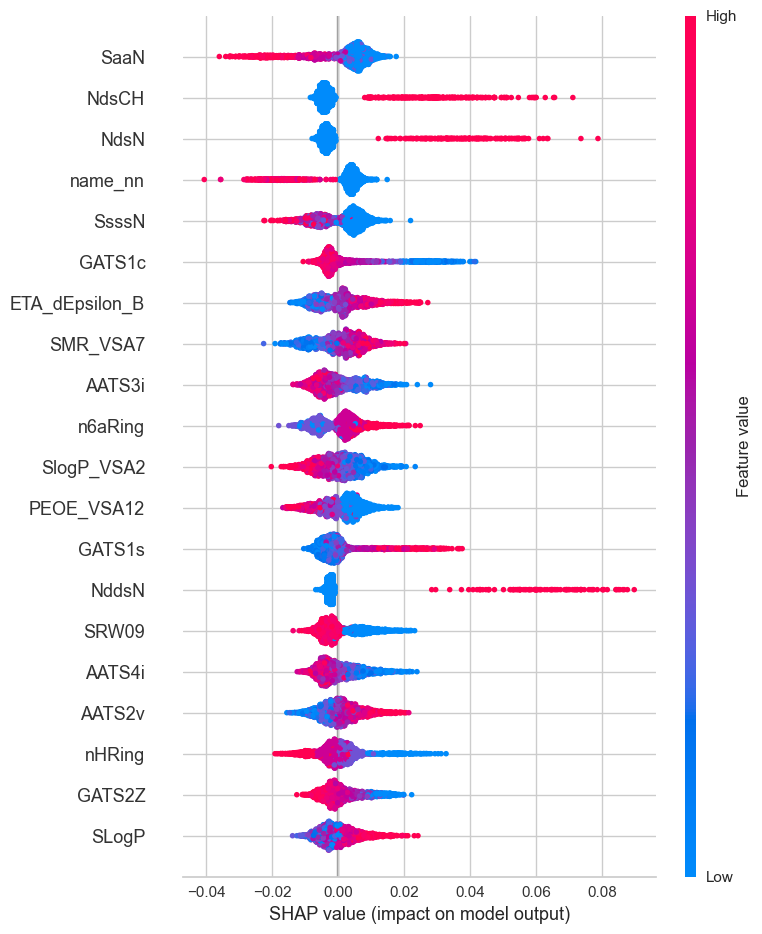

In [73]:
interpret_model(et)

In [71]:
lightgbm = create_model('lightgbm')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


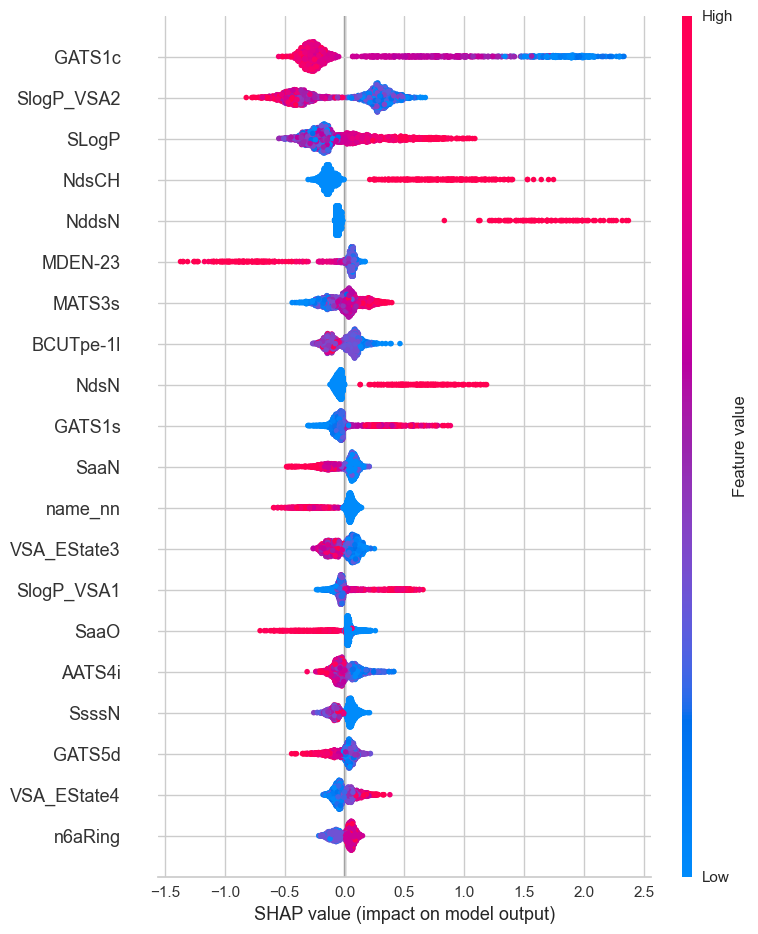

In [74]:
interpret_model(lightgbm)

In [72]:
xgboost = create_model('xgboost')

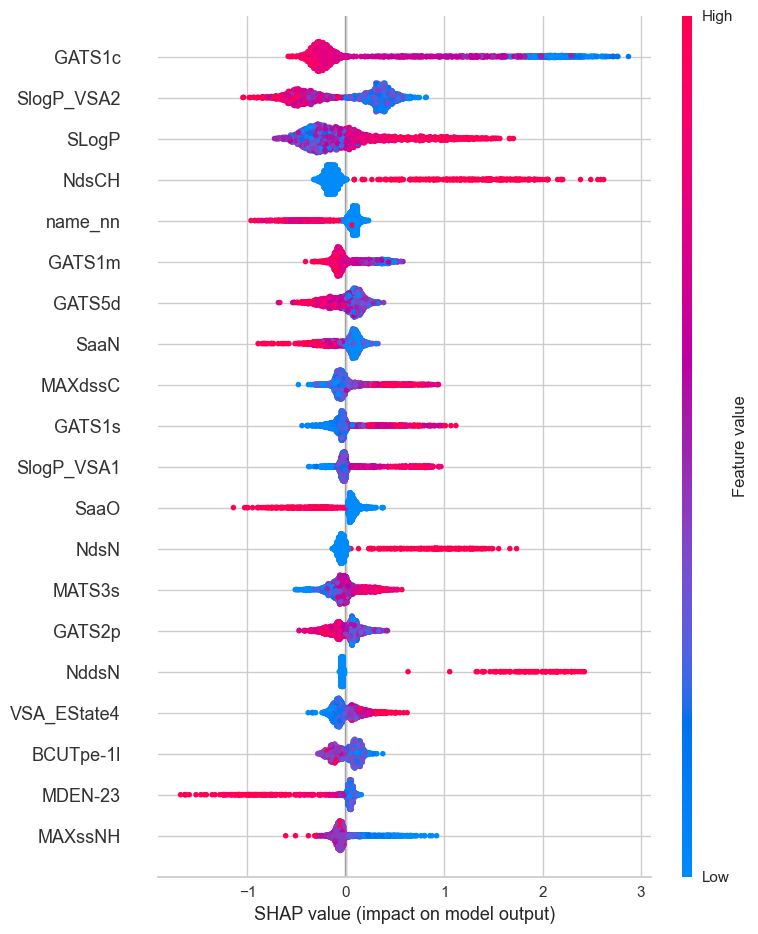

In [75]:
interpret_model(xgboost)

In [77]:
catboost = create_model('catboost')

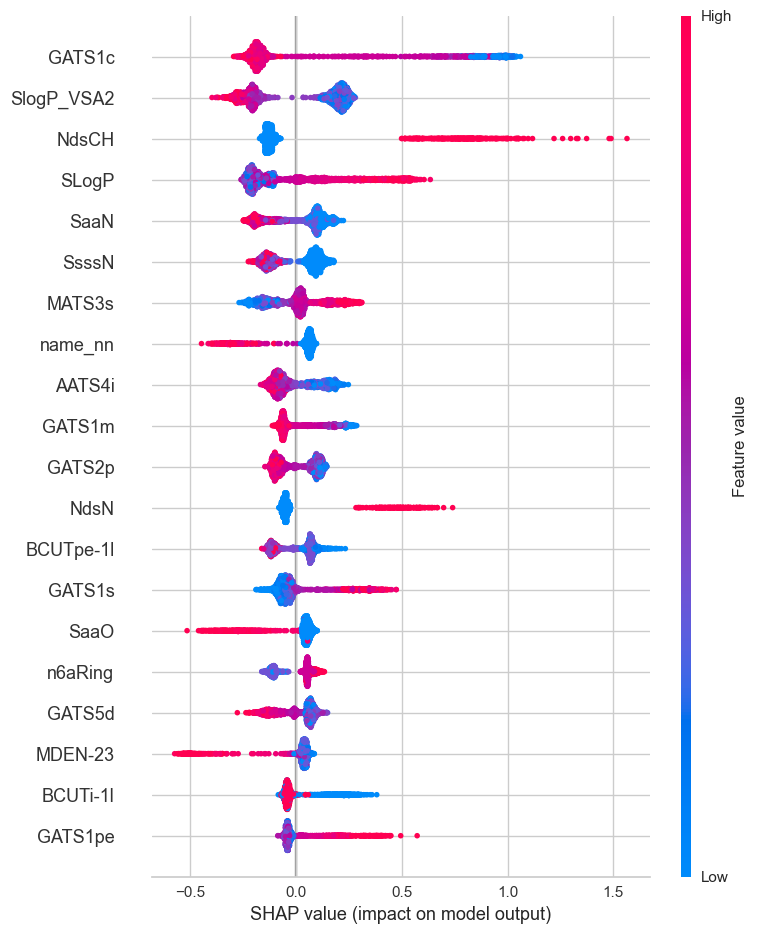

In [79]:
interpret_model(catboost)

In [81]:
tuned_xgboost = tune_model(xgboost, optimize = 'acc')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [83]:
tuned_et = tune_model(et, optimize = 'Precision')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [84]:
tuned_nb = tune_model(nb, optimize = 'recall')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [85]:
tuned_lgbm = tune_model(lightgbm, optimize = 'AUC')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightG

In [86]:
lst_tuned_models = [tuned_lgbm, et, tuned_nb, xgboost]
stack_tuned_models = stack_models(
    estimator_list = lst_tuned_models,
    meta_model = tuned_lgbm, 
    optimize = 'AUC'
)

[LightGBM] [Info] Number of positive: 3989, number of negative: 4082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103745
[LightGBM] [Info] Number of data points in the train set: 8071, number of used features: 663
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494239 -> initscore=-0.023046
[LightGBM] [Info] Start training from score -0.023046
[LightGBM] [Info] Number of positive: 3977, number of negative: 4095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103785
[LightGBM] [Info] Number of data points in the train set: 8072, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492691 -> initscore=-0.029239
[LightGBM] [Info] Start training from score -0.029239
[LightGBM] [

[LightGBM] [Info] Number of positive: 4414, number of negative: 4554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 8968, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492194 -> initscore=-0.031225
[LightGBM] [Info] Start training from score -0.031225
[LightGBM] [Info] Number of positive: 3531, number of negative: 3643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7174, number of used features: 2
[LightGBM] [Info] Number of positive: 3531, number of negative: 3643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

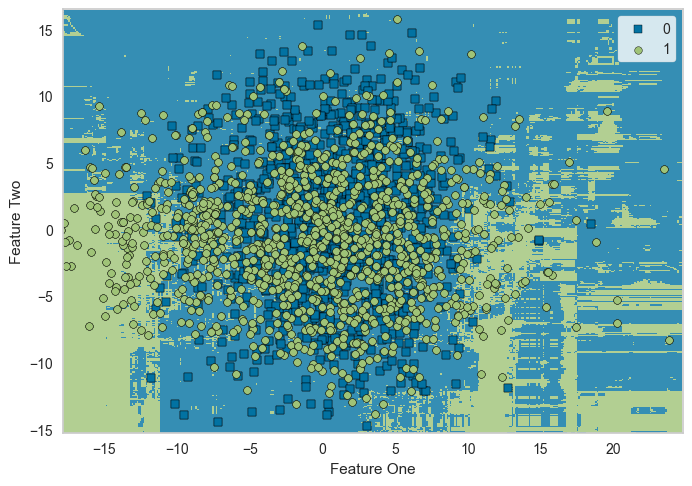

In [87]:
plt.figure(figsize = (8, 8))
plot_model(stack_tuned_models, plot = 'boundary')

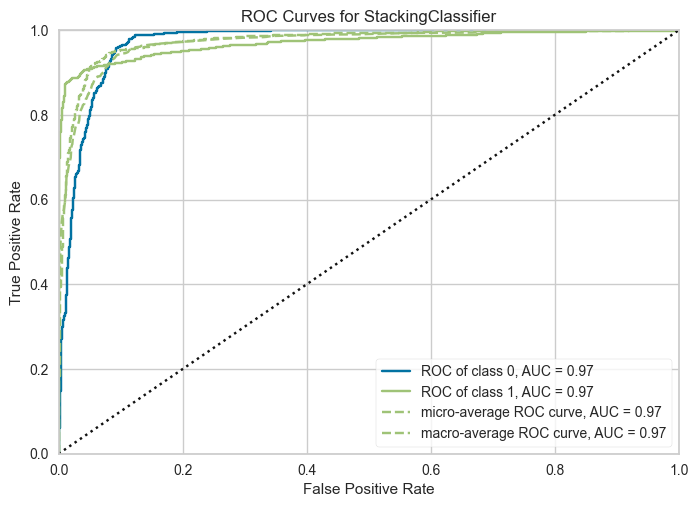

In [88]:
plt.figure(figsize = (8, 8))
plot_model(stack_tuned_models, plot = 'auc')

In [90]:
predict_model(stack_tuned_models)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.9749  
9441   76.968193  2500001643    1                 1            0.9901  
9442   68.207512  1900000680    1                 1            0.9983  
9443   83.161232        3588    1                 1            0.9551  
9444   69.501961         893    1                 0            0.8794  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.9764  
11796  65.778412        2792    0                 0            0.9218  
11797  58.703388        1425    0                 1            0.5374  
11798  80.516701        2754    0                 0            0.9982  
11799  85.695953        4067    0                 1            0.9585  

[2360 rows x 428 columns]

In [91]:
tune_stacked_model = tune_model(stack_tuned_models, optimize = 'AUC')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 3944, number of negative: 4127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103717
[LightGBM] [Info] Number of data points in the train set: 8071, number of used features: 661
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488663 -> initscore=-0.045355
[LightGBM] [Info] Start training from score -0.045355
[LightGBM] [Info] Number of positive: 3979, number of negative: 4093
[LightGBM] [Info] Number of positive: 3974, number of negative: 4097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103689
[LightGBM] [Info] Number of data points in the train set: 8072, number of used features: 663
[LightGBM] [In

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging

In [92]:
predict_model(tune_stacked_model)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.5423  
9441   76.968193  2500001643    1                 1            0.5569  
9442   68.207512  1900000680    1                 1            0.5599  
9443   83.161232        3588    1                 1            0.5382  
9444   69.501961         893    1                 0            0.5468  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.5663  
11796  65.778412        2792    0                 0            0.5632  
11797  58.703388        1425    0                 0            0.5249  
11798  80.516701        2754    0                 0            0.5724  
11799  85.695953        4067    0                 1            0.5261  

[2360 rows x 428 columns]

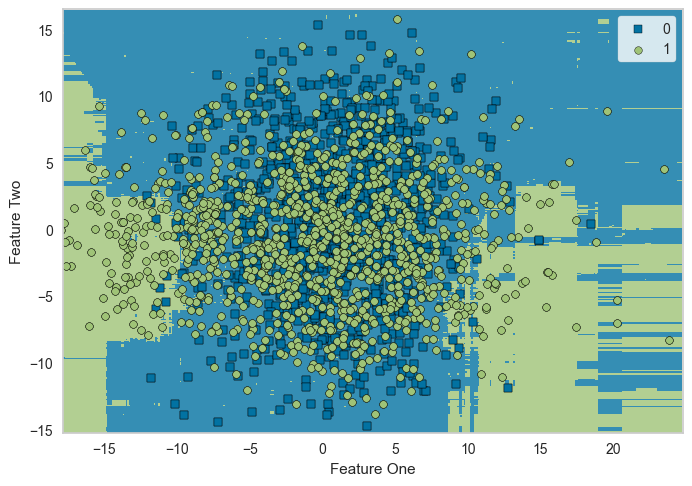

In [93]:
plt.figure(figsize = (8, 8))
plot_model(tune_stacked_model, plot = 'boundary')

In [94]:
blend_soft = blend_models(estimator_list = lst_tuned_models, optimize = 'AUC', method = 'soft')

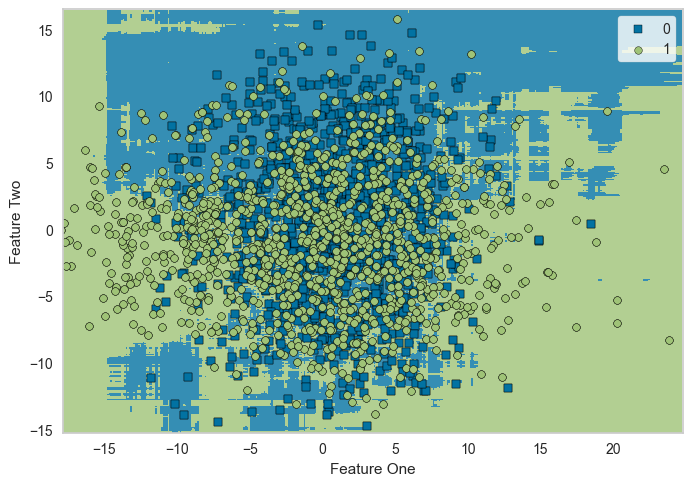

In [95]:
plt.figure(figsize = (8,8))
plot_model(blend_soft, plot = 'boundary')

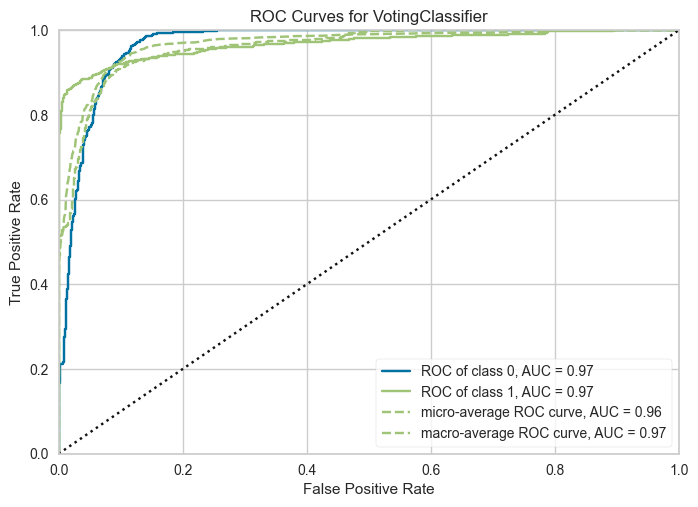

In [97]:
plt.figure(figsize = (8,8))
plot_model(blend_soft, plot = 'auc')

In [98]:
predict_model(blend_soft)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.8105  
9441   76.968193  2500001643    1                 1            0.9782  
9442   68.207512  1900000680    1                 1            0.9992  
9443   83.161232        3588    1                 1            0.9000  
9444   69.501961         893    1                 0            0.5016  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.7087  
11796  65.778412        2792    0                 0            0.6458  
11797  58.703388        1425    0                 1            0.6818  
11798  80.516701        2754    0                 0            0.7327  
11799  85.695953        4067    0                 1            0.8732  

[2360 rows x 428 columns]

In [104]:
blend_hard = blend_models(
    estimator_list = lst_tuned_models,
    optimize = 'acc',
    method = 'hard'
)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

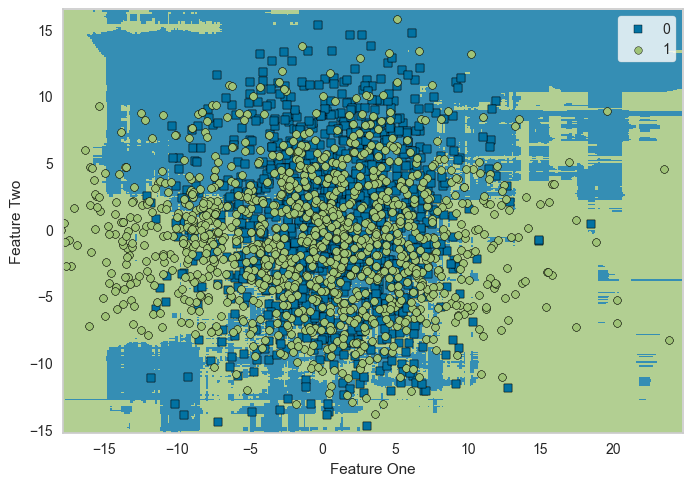

In [105]:
plt.figure(figsize = (8,8))
plot_model(blend_hard, plot = 'boundary')

In [108]:
predict_model(blend_hard)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI6      JGI7      JGI8      JGI9     JGI10  \
9440   4276.907715  ...  0.021513  0.015239  0.012346  0.011111  0.007231   
9441   5033.080566  ...  0.017259  0.014799  0.009747  0.006720  0.006224   
9442   3958.768311  ...  0.012336  0.013423  0.014577  0.010000  0.012346   
9443   8424.211914  ...  0.024084  0.009292  0.006725  0.011603  0.009004   
9444   3757.420898  ...  0.014768  0.014760  0.010478  0.004923  0.005679   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.023580  0.007815  0.008781  0.007604  0.005643   
11796  7033.656250  ...  0.014950  0.013889  0.011329  0.006296  0.003958   
11797  4449.249512  ...  0.020231  0.012626  0.012886  0.009079  0.007972   
11798  8778.245117  ...  0.010986  0.010915  0.010338  0.007533  0.006604   
11799  8369.335938  ...  0.016562  0.007127  0.008167  0.006885  0.003058   

          SRW09     TSRW10       WPath  cls  prediction_label  
9440   0.000000  57.292469        1302    1                 0  
9441   7.525640  76.968193  2500001643    1                 1  
9442   7.195187  68.207512  1900000680    1                 1  
9443   6.951772  83.161232        3588    1                 1  
9444   6.861712  69.501961         893    1                 0  
...         ...        ...         ...  ...               ...  
11795  7.247793  68.846703         940    0                 0  
11796  0.000000  65.778412        2792    0                 0  
11797  0.000000  58.703388        1425    0                 1  
11798  6.605298  80.516701        2754    0                 0  
11799  6.842683  85.695953        4067    0                 1  

[2360 rows x 427 columns]

In [109]:
best_model = compare_models([tune_stacked_model, stack_tuned_models, blend_hard, blend_soft])

In [110]:
predict_model(best_model)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.5423  
9441   76.968193  2500001643    1                 1            0.5569  
9442   68.207512  1900000680    1                 1            0.5599  
9443   83.161232        3588    1                 1            0.5382  
9444   69.501961         893    1                 0            0.5468  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.5663  
11796  65.778412        2792    0                 0            0.5632  
11797  58.703388        1425    0                 0            0.5249  
11798  80.516701        2754    0                 0            0.5724  
11799  85.695953        4067    0                 1            0.5261  

[2360 rows x 428 columns]

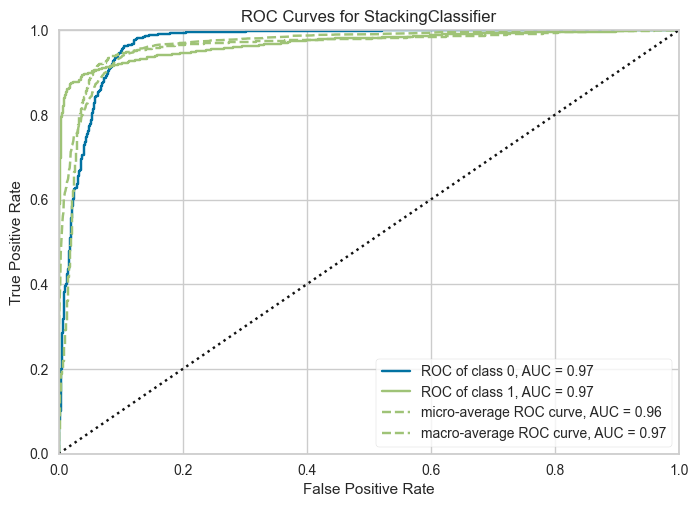

In [111]:
plot_model(best_model, plot = 'auc')

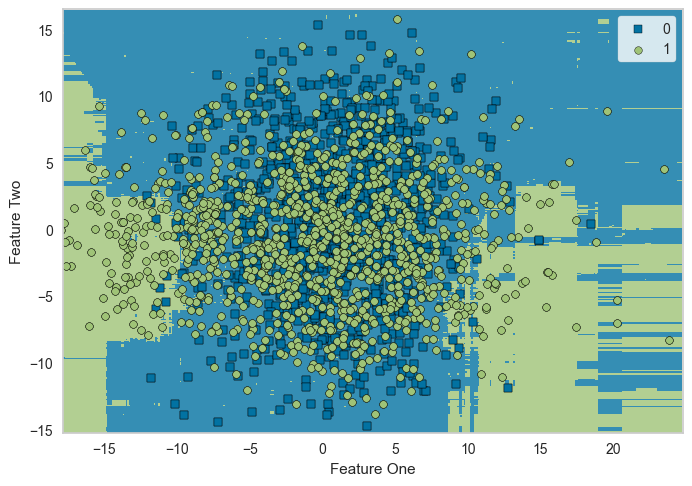

In [112]:
plot_model(best_model, plot = 'boundary')

In [114]:
cali_model = calibrate_model(best_model)

Initiated  . . . . . . . . . . . . . . . . . .              01:35:05
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [115]:
predict_model(cali_model)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.8340  
9441   76.968193  2500001643    1                 1            0.9598  
9442   68.207512  1900000680    1                 1            0.9727  
9443   83.161232        3588    1                 1            0.7553  
9444   69.501961         893    1                 0            0.8448  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.9619  
11796  65.778412        2792    0                 0            0.9491  
11797  58.703388        1425    0                 1            0.5794  
11798  80.516701        2754    0                 0            0.9720  
11799  85.695953        4067    0                 1            0.7267  

[2360 rows x 428 columns]

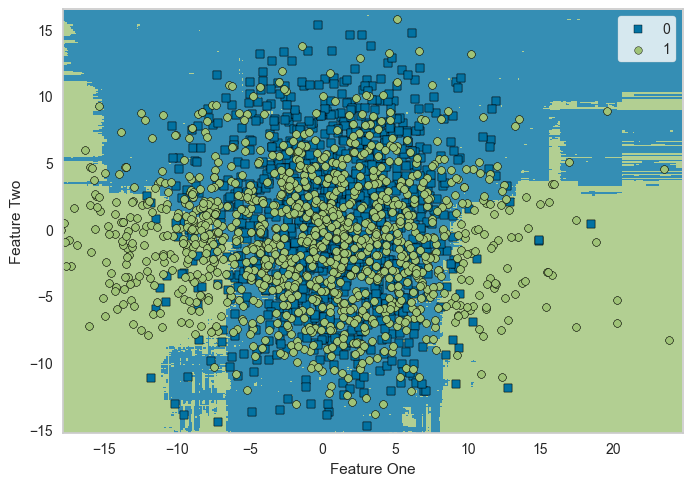

In [120]:
plot_model(cali_model, plot = 'boundary')

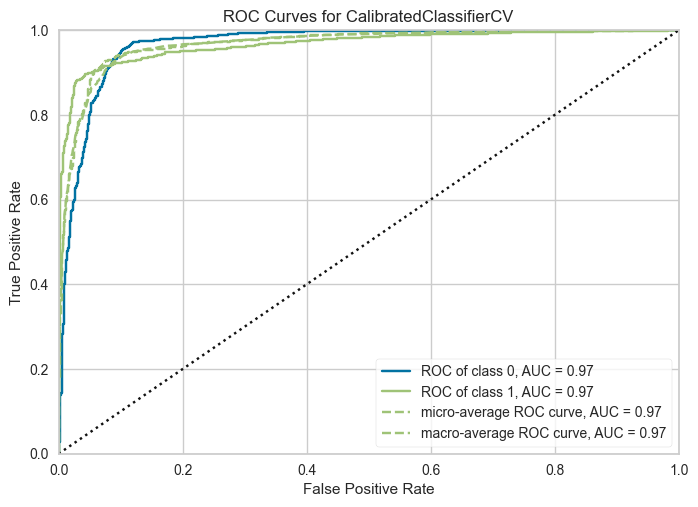

In [119]:
plot_model(cali_model)

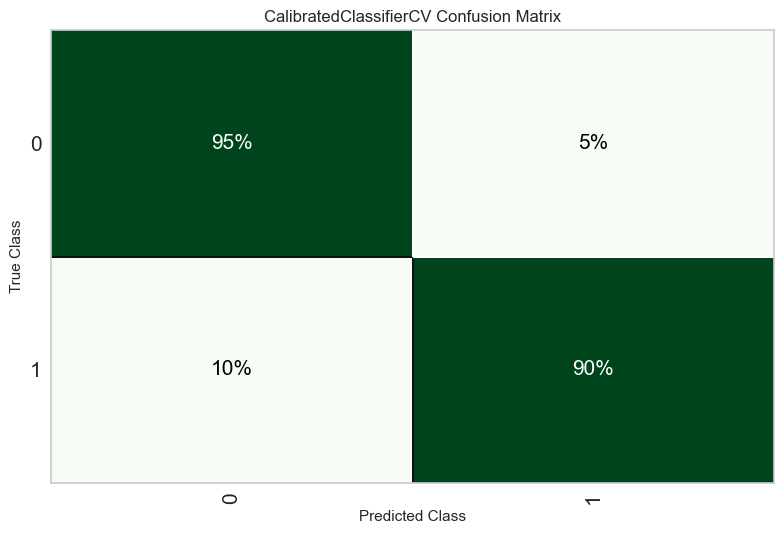

In [124]:
plot_model(cali_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

In [125]:
predict_model(cali_model)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.8340  
9441   76.968193  2500001643    1                 1            0.9598  
9442   68.207512  1900000680    1                 1            0.9727  
9443   83.161232        3588    1                 1            0.7553  
9444   69.501961         893    1                 0            0.8448  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.9619  
11796  65.778412        2792    0                 0            0.9491  
11797  58.703388        1425    0                 1            0.5794  
11798  80.516701        2754    0                 0            0.9720  
11799  85.695953        4067    0                 1            0.7267  

[2360 rows x 428 columns]

In [126]:
predict_model(stack_tuned_models)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.9749  
9441   76.968193  2500001643    1                 1            0.9901  
9442   68.207512  1900000680    1                 1            0.9983  
9443   83.161232        3588    1                 1            0.9551  
9444   69.501961         893    1                 0            0.8794  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.9764  
11796  65.778412        2792    0                 0            0.9218  
11797  58.703388        1425    0                 1            0.5374  
11798  80.516701        2754    0                 0            0.9982  
11799  85.695953        4067    0                 1            0.9585  

[2360 rows x 428 columns]

In [127]:
predict_model(tune_stacked_model)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.5423  
9441   76.968193  2500001643    1                 1            0.5569  
9442   68.207512  1900000680    1                 1            0.5599  
9443   83.161232        3588    1                 1            0.5382  
9444   69.501961         893    1                 0            0.5468  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.5663  
11796  65.778412        2792    0                 0            0.5632  
11797  58.703388        1425    0                 0            0.5249  
11798  80.516701        2754    0                 0            0.5724  
11799  85.695953        4067    0                 1            0.5261  

[2360 rows x 428 columns]

In [128]:
predict_model(blend_hard)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI6      JGI7      JGI8      JGI9     JGI10  \
9440   4276.907715  ...  0.021513  0.015239  0.012346  0.011111  0.007231   
9441   5033.080566  ...  0.017259  0.014799  0.009747  0.006720  0.006224   
9442   3958.768311  ...  0.012336  0.013423  0.014577  0.010000  0.012346   
9443   8424.211914  ...  0.024084  0.009292  0.006725  0.011603  0.009004   
9444   3757.420898  ...  0.014768  0.014760  0.010478  0.004923  0.005679   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.023580  0.007815  0.008781  0.007604  0.005643   
11796  7033.656250  ...  0.014950  0.013889  0.011329  0.006296  0.003958   
11797  4449.249512  ...  0.020231  0.012626  0.012886  0.009079  0.007972   
11798  8778.245117  ...  0.010986  0.010915  0.010338  0.007533  0.006604   
11799  8369.335938  ...  0.016562  0.007127  0.008167  0.006885  0.003058   

          SRW09     TSRW10       WPath  cls  prediction_label  
9440   0.000000  57.292469        1302    1                 0  
9441   7.525640  76.968193  2500001643    1                 1  
9442   7.195187  68.207512  1900000680    1                 1  
9443   6.951772  83.161232        3588    1                 1  
9444   6.861712  69.501961         893    1                 0  
...         ...        ...         ...  ...               ...  
11795  7.247793  68.846703         940    0                 0  
11796  0.000000  65.778412        2792    0                 0  
11797  0.000000  58.703388        1425    0                 1  
11798  6.605298  80.516701        2754    0                 0  
11799  6.842683  85.695953        4067    0                 1  

[2360 rows x 427 columns]

In [129]:
predict_model(blend_soft)

name  nAcid  nBase  \
9440          CC1=CC(=C(C(=C1C)S(=O)(=O)NCCCN2CCOCC2)C)C      0    1.0   
9441   CC1=C(N2C=CC=NC2=N1)C3=CSC(=N3)NC4=CC=C(C=C4)N...      0    0.0   
9442     CC1=[N+](C2=C(N1C)C=C(C=C2)Cl)CC3=CC=CC=C3.[I-]      1    1.0   
9443   C1CC(OC1)CNS(=O)(=O)C2=CC=C(C=C2)C3=CC=C(C=C3)...      0    0.0   
9444            CC1=CC=CN2C1=NC(=C2)C3=CC4=CC=CC=C4OC3=O      0    0.0   
...                                                  ...    ...    ...   
11795             CC1=NN=C(O1)SCC(=O)NC2=CC3=C(C=C2)OCO3      0    0.0   
11796  C1CC(CN(C1)S(=O)(=O)C2=CC=CC=C2)C(=O)NC3=CC=C(...      0    0.0   
11797  CC1=C(C=C(C=C1)NC(=O)CN2C(=O)C3=CC=CC=C3C(=N2)C)F      0    0.0   
11798  CCCC1=NC2=NC=NN2C(=C1)N3CCCC(C3)C(=O)NC4=C(C=C...      0    0.0   
11799  C1CC2=CC=CC=C2N(C3=CC=CC=C31)C(=O)CN4N=C(N=N4)...      2    0.0   

        SpMax_A   SpMAD_A     VE1_A       VR1_A  nBr         ATS2m  \
9440   2.465332  1.229564  3.652364  768.452637    0   6814.648438   
9441   2.438862  1.294084  4.086513  247.596832    1   7488.730469   
9442   2.438862  1.294084  4.086513  247.596832    0   5442.681641   
9443   2.409595  1.293957  4.871051  355.804138    0  10558.621094   
9444   2.482653  1.331947  4.223250  130.264526    0   5809.644043   
...         ...       ...       ...         ...  ...           ...   
11795  2.370723  1.301287  3.607111  247.863861    0   6316.258301   
11796  2.432201  1.323149  4.267554  551.324890    0   9136.021484   
11797  2.443993  1.275908  3.878948  329.857819    0   6326.751465   
11798  2.468043  1.314685  4.425002  434.618866    0   8279.666016   
11799  2.476490  1.363277  4.641021  883.812805    0   9506.536133   

             ATS6m  ...      JGI7      JGI8      JGI9     JGI10     SRW09  \
9440   4276.907715  ...  0.015239  0.012346  0.011111  0.007231  0.000000   
9441   5033.080566  ...  0.014799  0.009747  0.006720  0.006224  7.525640   
9442   3958.768311  ...  0.013423  0.014577  0.010000  0.012346  7.195187   
9443   8424.211914  ...  0.009292  0.006725  0.011603  0.009004  6.951772   
9444   3757.420898  ...  0.014760  0.010478  0.004923  0.005679  6.861712   
...            ...  ...       ...       ...       ...       ...       ...   
11795  3759.669434  ...  0.007815  0.008781  0.007604  0.005643  7.247793   
11796  7033.656250  ...  0.013889  0.011329  0.006296  0.003958  0.000000   
11797  4449.249512  ...  0.012626  0.012886  0.009079  0.007972  0.000000   
11798  8778.245117  ...  0.010915  0.010338  0.007533  0.006604  6.605298   
11799  8369.335938  ...  0.007127  0.008167  0.006885  0.003058  6.842683   

          TSRW10       WPath  cls  prediction_label  prediction_score  
9440   57.292469        1302    1                 0            0.8105  
9441   76.968193  2500001643    1                 1            0.9782  
9442   68.207512  1900000680    1                 1            0.9992  
9443   83.161232        3588    1                 1            0.9000  
9444   69.501961         893    1                 0            0.5016  
...          ...         ...  ...               ...               ...  
11795  68.846703         940    0                 0            0.7087  
11796  65.778412        2792    0                 0            0.6458  
11797  58.703388        1425    0                 1            0.6818  
11798  80.516701        2754    0                 0            0.7327  
11799  85.695953        4067    0                 1            0.8732  

[2360 rows x 428 columns]

I think stack tuned model and cali model both are equally good but stack tuned model is better. One is the calibrated version of the other, and both have similar scores and a very good AUC score as well. 

Final Accuaracy Acheived : 93.05%